<a href="https://colab.research.google.com/github/Bertimaz/Data-Science/blob/main/Movie_Budget_Evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Budget Evolution Analysis.**


# Libraries and keys import





##Importing Libraries

In [1]:
from google.colab import drive
from configparser import ConfigParser
import requests, locale,matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from bs4 import BeautifulSoup
import requests as rq
import re
import bs4
import time
import  lxml
import random
from google.colab import data_table
data_table.enable_dataframe_formatter()








## Importing Keys

In [2]:
#Mounting drive
drive.mount('/content/gdrive')
# Retrieving TMDB key
API_keys_path='/content/gdrive/MyDrive/MovieBudgetEvolution/API_keys.cfg'
parser=ConfigParser()
parser.read(API_keys_path)
TMDB_api_key= parser.get('TMDB_API', 'auth_key')

Mounted at /content/gdrive


#Searching information at IMDB

## Functions and objects

In [ ]:
## Defining object Movie
class Movie:
  def __init__(self,id,budget):
    self.ID = id
    self.budget = budget

## Fuction that returns object Movie with information from Mojo. URL is given by the table at mojo's world wid box office by year https://www.boxofficemojo.com/year/world/?ref_=bo_nb_hm_tab
def retrieveMovieInfo(url): 
  #add the beginning of the URL
  url='https://www.boxofficemojo.com'+url
  # Find the URL to the complete movie page
  url=retrieveMoviePageUrl(url)
  #Transform HTML response to Beautiful Soup Object
  r=rq.get(url)        
  p=BeautifulSoup(r.text,'html.parser')

  try:
    #Look for the main tag
    main=p.find('main')

    #Look for the first div tag
    b=main.find('div')

    #Look for the third tag, then the forth, then the third,then the second,then the first, then the first
    c=b.contents[2].contents[3].contents[2].contents[1].contents[0].contents[0]
  except:
    #if it can't retrieve information sabe budget as 0
    c='0'
    

  # Remove all special characther from budget
  budget=re.sub('[^A-Za-z0-9-. ]+', '', c)
  
  #Extract IMDB ID from url
  id=re.sub("https://www.boxofficemojo.com/title/","",url)
  id=re.sub("/?ref_=bo_gr_ti",'',id)
  id=id.replace('/?','')
  
  #Create object with info and return it
  movie= Movie(id, budget) 
  return movie

##Fucntion that retrieves url for the complete movie page from the Url for the basic movie page
def retrieveMoviePageUrl(url):
  #Get Html response and transform to Beautiful Soup Object
  r=rq.get(url)        
  p=BeautifulSoup(r.text,'html.parser') 
  
  try:
    #Look for the main tag
    main=p.find('main')

    #Look for the first div tag
    b=main.find('div')

    #Look for the second div tag
    c=b.contents[1]


    #Look for the first div tag
    d=c.contents[0]
    # #look fot the attribute href from first tag 'a'
    e=d.find('a')['href']

  except:
    ##If unable to findo URL saves URL as blank
    print('Could not find url for complete information ' + str(url))
    e=''

  #Completes URL
  url='https://www.boxofficemojo.com'+ e

  # Return URL
  return str(url)

#Fucntion that replaces ',' for ''
def convdollar(x):
    """
    Just a parsing function converting 3,256 to 3256
    """
    if ',' in x:
        return float(x.replace(',',''))
    


##Create necessary Lists and variables
passedYears=[]
errors=[]
years=[str(a) for a in range(1980,2021)]
df_list=[]
control=0

## Scraping Mojo WebSite

In [ ]:


#Loop that goes through every box office year page
for year in years:
  # Complete URL with correct year
  url='https://www.boxofficemojo.com/year/world/'+year+'/'

  #Transforms HTML response to Beautiful Soup object
  r=rq.get(url)        
  p=BeautifulSoup(r.text,'html.parser')
  
  #Loop for IMDB error
  isBroken=False
  while(True):
    try:
      ### Look for the table ### 
      b=p.find_all('table')
    
      ### Usually the first table object on page ### 
      tb=b[0].find_all('td')  

      #If finds information exits loop  
      break
    
    except:
      #if doesn't find wait 2 seconds
      control=control+1
      time.sleep(2)

    ##If try more than 10 times gives up and break loop
    if(control>10):
      tb=None
      print('Error at year ' + year+ ' url:' + url)
      passedYears.append(year)
      errors.append(['year',str(b)])
      isBroken=True
      break

  #If information is no available, goes to next year
  if(isBroken):
    continue

  #If information is available append to data
  
  #Create data list
  data=[]
  #Variable to controle table column
  table_column=0

  ##Loop Through every element at the table
  for i in tb:
    # The second column is the movie name and has the URL for the webpage
    if (table_column%7==1):  
      #Create movie object from url from table  
      movie = retrieveMovieInfo(i.find('a')['href'])      
      
      #Append Movie name
      data.append(i.find('a').contents[0])
      ## Append Movie budget
      data.append(str(movie.budget))
      ## Append Movie IMDB ID
      data.append(str(movie.ID))
    
    ## The Second COlumn is the movie budget
    elif(table_column%7==2):
      ## Append Movie worldwide budget
      data.append(str(i.contents[0]))
    else:
      ##Append other information
      data.append(str(i.contents[0]))

    # Control wich column we are
    table_column=table_column+1

  print('Box Office data for %s scraped' % year)
        
        
  
  ### Strip special characters ### 
  data=[re.sub('[^A-Za-z0-9-. ]+', '', a) for a in data]
  
  ### Fill NaNs ### 
  data=[np.nan if a =='na' else a for a in data]
  
  ### Define the feature names ###
  columns=['rank', 'title','budget','IMDB_id', 'revenue' ,'domesticRevenue', 'percentage', 'foreign', 'percentage2'  ]
  
 
  ### Escape clause in case the layout changes from year to year ### 
  if len(data)%len(columns) != 0:
      print('Possible table misalignment in table for year %s' % year)
      break 
  
  ### Convert to pandas dataframe ### 
  nrow=int(len(data)/len(columns))
  df=pd.DataFrame(np.array(data).reshape(nrow,len(columns)),columns=columns)
  df['year']=int(year)
  df_list.append(df)
  main=pd.concat([main,df])

  # Store data into csv
  main.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/annual_mojo.csv')


# Retrieving movies' information from TMDB 



In [ ]:
initial_year=1980
end_year=2021

# Create list with years to serch
years=range(initial_year,end_year+1)
# Create list with DataFrame's columns 
columns=['film', 'revenue', 'budget', 'release_date','imdb_id']
#Creating DataFrame
movies_df=pd.DataFrame(columns=columns)

#Creating list with number of pages to search TMDB for movies from each year
pages=[1,2]

# Loop for each year
for year in years:
  #Loop for each page
  for page in pages:
    #Creating URL
    url='https://api.themoviedb.org/3/discover/movie?api_key=' +  TMDB_api_key +'&primary_release_year='+ str(year) +'&page='+str(page)+'&sort_by=revenue.desc'
    response=requests.get(url)
    #Transforming json to python list
    movies_list_json=response.json()
    movies_list = movies_list_json['results']

    #Loop to search aditional information on TMDB API
    for movie in movies_list:
      #Get response from URL for each movie
      movie_revenue=requests.get('https://api.themoviedb.org/3/movie/'+ str(movie['id']) +'?api_key='+ TMDB_api_key+'&language=en-US')
      #Save information as Json
      movie_revenue=movie_revenue.json()
      #Add Movie info in the last line of  movies_df
      movies_df.loc[len(movies_df)]=[movie['title'],movie_revenue['revenue'],(movie_revenue['budget']), movie_revenue['release_date'],movie_revenue['imdb_id']]





In [ ]:
# Print Tail
movies_df.tail(n=30)

,Unnamed: 0,film,revenue,budget,release_date,imdb_id
1410,2810,Bloodshot,39861118,42000000,2020-03-05,tt1634106
1411,2811,Peninsula,39657073,17000000,2020-07-15,tt8850222
1412,2812,Unhinged,39238300,33000000,2020-07-16,tt10059518
1413,2813,The Confidence Man JP – Episode of the Princess –,35762324,0,2020-07-23,tt12767996
1414,2814,Deliver Us from Evil,34662454,12000000,2020-08-05,tt12763920
1415,2815,Invasion,32104054,8819200,2020-01-01,tt8060328
1416,2816,Honest Thief,31220247,0,2020-09-03,tt1838556
1417,2817,Ala Vaikunthapurramuloo,28859072,14000000,2020-01-12,tt9537292
1418,2818,Scoob!,28559165,90000,2020-07-09,tt3152592
1419,2819,Vanguard,27900000,0,2020-09-30,tt9695722


Cleaning duplicates and incomplete entries.

In [ ]:
# Erase Duplicates
movies_df = movies_df.drop_duplicates()

# Erase movies without budget or revenue
movies_df_clean = movies_df[(movies_df.revenue!=0) | (movies_df.budget!=0)]
movies_df_clean = movies_df_clean[movies_df_clean.budget!=0]


##Preliminary Analysis

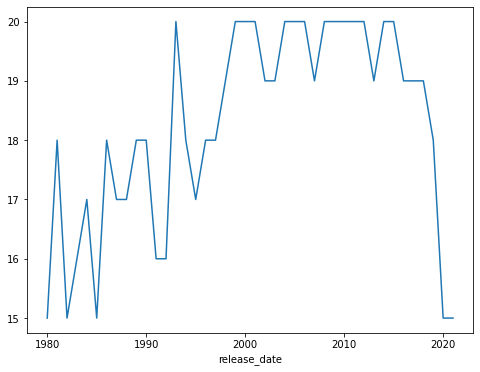

In [ ]:
#Converting release date type to datetime
movies_df_clean['release_date']=pd.to_datetime(movies_df_clean['release_date'])

#Printing information
count_df=movies_df_clean.release_date.groupby([movies_df_clean.release_date.dt.year]).agg('count')
fig, ax = plt.subplots(figsize=(8,6))
bp = count_df.plot(ax=ax)



We don't have enough information ( around 20 production for each year). So let's search other databases.

 

# Merging DataFrames

In [ ]:
# Read CSV
tmdb_df=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/movie_revenue_TMDB.csv')
imdb_df=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/annual_mojo.csv')

# drop unimportant columns
imdb_df =imdb_df.drop(columns=['Unnamed: 0','rank', 'domesticRevenue','percentage','foreign','percentage2'])
tmdb_df = tmdb_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1'])


#Clean Entries before 1980 or without release dates
tmdb_df = tmdb_df[~(tmdb_df['release_date']<'1980-01-01')]
tmdb_df= tmdb_df[tmdb_df['release_date'].notna()]


#Drop all string budgets
imdb_df=imdb_df.replace(regex=['See more details at IMDbPro'],value=0)

#Correct columns Types
imdb_df['budget']=imdb_df['budget'].astype(int)
imdb_df['revenue']=imdb_df['revenue'].astype(int)
imdb_df['year']=imdb_df['year'].astype(int)
tmdb_df = tmdb_df.astype({'imdb_id':'string'})

#Create new DF  and drop duplicates
union_db=imdb_df.copy()
union_db=union_db.drop_duplicates()

# iterate imdb databframe getting mising info from tmdb_df
for index, row in union_db.iterrows():
  
  # check for lacking budget on IMDB
  if row['budget']==0:  
    #Saving Movie IMDB id   
    imdb_id=row['IMDB_id']
    #saving movie information from TMDB  
    movie_tmdb =tmdb_df.loc[tmdb_df["imdb_id"]==imdb_id]
    #If Movie exists in TMDB
    if not movie_tmdb.empty:
      #Saves TMDB budget
      tmdb_budget = tmdb_df.loc[tmdb_df["imdb_id"]==row['IMDB_id']].iloc[0]['budget']
      #If TMDB budget is diferent from 0
      if tmdb_budget!=0:
        #Save TMDB budget at dataframe
        row['budget'] = tmdb_budget
        print (row['title']+ ' budget was changed to '+ str(tmdb_budget))
  
  # check for lacking revenue on IMDB
  if row['revenue']==0:    
    #Saving Movie IMDB id   
    imdb_id=row['IMDB_id']
    #saving movie information from TMDB    
    movie_tmdb =tmdb_df.loc[tmdb_df["imdb_id"]==imdb_id]
    #If Movie exists in TMDB
    if not movie_tmdb.empty:
      #Saves TMDB revenue
      tmdb_revenue = tmdb_df.loc[tmdb_df["imdb_id"]==row['IMDB_id']].iloc[0]['revenue']
      #If TMDB budget is diferent from 0
      if tmdb_revenue!=0:
        #Save TMDB budget at dataframe
        row['revenue'] = tmdb_revenue
        print (row['title']+ ' revenue was changed to '+ str(tmdb_revenue))

          
print("TMDB dataframe checked")
   
# Salvando o novo dataframe em um arquivo CSV
union_db=union_db.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
union_db.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/unionDB.csv',index=False)




# Data Preparation

## Complementary Function

In [44]:
# Load Inflation information from excel
inflation = pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/USA_INFLATION.csv',index_col=[0])
inflation= inflation.drop("Unnamed: 0.1",axis=1)
inflation= inflation.drop("Unnamed: 0.1.1",axis=1)
inflation= inflation.drop("Unnamed: 0.1.1.1",axis=1)
inflation= inflation.drop("Unnamed: 0.1.1.1.1",axis=1)

# Create inflation multiplier column
inflation['multiplier'] = inflation['Inflation'].iloc[-1]/inflation['Inflation']

inflation['Date']=pd.to_datetime(inflation["Date"])
inflation

,Date,Inflation,multiplier
0,1980-01-01,82.408333,3.288135
1,1981-01-01,90.925000,2.980146
2,1982-01-01,96.500000,2.807977
3,1983-01-01,99.600000,2.720580
4,1984-01-01,103.883333,2.608404
5,1985-01-01,107.566667,2.519087
6,1986-01-01,109.608333,2.472164
7,1987-01-01,113.625000,2.384772
8,1988-01-01,118.258333,2.291337
9,1989-01-01,123.966667,2.185828


In [32]:
#Function that return summary by decade
def summarize(movies_df):
  ##Set period list
  firstYear=1980
  lastYear=2021
  timeStep=10
  period=list(range(firstYear,lastYear+1,timeStep))
  #Create necessary dataframes
  current_df=pd.DataFrame(columns=['decade','budget_mean','revenue_mean','returnRate_mean','budgetCategory'])
  summary_df=pd.DataFrame(columns=['decade','budget_mean','revenue_mean','returnRate_mean','budgetCategory'])

  ##Loops that iterates movie categories
  for category in budget_categories:

    #Loops every year
    for year in period:
      ##Saves movies from current period and movie category
      currentPeriodMovies = movies_df[(movies_df['year'].dt.year>=year) & (movies_df['year'].dt.year<year+timeStep) & 
                                              (movies_df['budget_category']==category).copy() ]
      ### Save Period information
      budget_mean = currentPeriodMovies['budget_updated'].mean()
      revenue_mean = currentPeriodMovies['revenue_updated'].mean()
      returnRate_mean = currentPeriodMovies['return_rate'].mean()
      ## Save period information to dataFrame
      current_df=current_df.append({'decade' : year, 'budget_mean' : budget_mean , 'revenue_mean' : revenue_mean, 'returnRate_mean' : returnRate_mean, 
                                    'budgetCategory':category},ignore_index=True)
      #Erase current period DataFrame
      currentPeriodMovies=currentPeriodMovies.iloc[0:0]
    
    #Append current budget category DataFrame to summary
    summary_df=summary_df.append(current_df,ignore_index=True)
    #Erase currente budget category dataFrame
    current_df=current_df.iloc[0:0]
  
  #Rounding Values to two decimal places
  summary_df['revenue_mean']=summary_df['revenue_mean'].round(decimals = 2)
  summary_df['budget_mean']=summary_df['budget_mean'].round(decimals = 2)
  summary_df['returnRate_mean']=summary_df['returnRate_mean'].round(decimals = 2)
  ##Return DataFrame
  return summary_df


#Function that returns DataFrames with budget and revenue adjusted by inflation        
def updateByInflation(inflation, movies_df):

 
  #copying df
  new_movies_df=movies_df.copy()
  new_movies_df['year']=pd.to_datetime(new_movies_df['year'], format ='%Y')



  # Merging Movies DataFrame with Inflation DataFrame
  new_movies_df=pd.merge(new_movies_df.assign(grouper=new_movies_df['year'].dt.to_period('Y')),inflation.assign(grouper=inflation['Date'].dt.to_period('Y')), how='left', left_on='grouper', right_on='grouper').drop(columns = ['Date','Inflation','grouper'])


  # Adjusting budget and revenue
  new_movies_df['budget_updated'] = new_movies_df['budget'] * new_movies_df['multiplier']
  new_movies_df['revenue_updated'] = new_movies_df['revenue'] * new_movies_df['multiplier']

  #Return dataFrame with adjusted values
  return new_movies_df.drop(columns=["IMDB_id", "revenue", "budget","multiplier"])


## DataFrame Preparation


In [45]:
#Adjust By Inflation
union_db_adjusted=updateByInflation(inflation,union_db).copy()

#Drop row without complete info
union_db_adjusted = union_db_adjusted[(union_db_adjusted.budget_updated!=0) | (union_db_adjusted.revenue_updated!=0)]
union_db_adjusted = union_db_adjusted[(union_db_adjusted.budget_updated!=0)]

#Drop Movies after 2020
union_db_adjusted=union_db_adjusted.drop(union_db_adjusted[union_db_adjusted.year.dt.year>=2020].index)


In [47]:
#Dividing budget and revenue by 10^6 for easy reading
union_db_adjusted['budget_updated']=union_db_adjusted['budget_updated']/1000000
union_db_adjusted['revenue_updated']=union_db_adjusted['revenue_updated']/1000000

#Rounding Values to two decimal places
union_db_adjusted['budget_updated']=union_db_adjusted['budget_updated'].round(decimals = 2)
union_db_adjusted['revenue_updated']=union_db_adjusted['revenue_updated'].round(decimals = 2)

In [50]:

#Creating buckets of small(<5 Millions), medium (5<x<60 Millions) and high budget (x>60 Millions)
conditions = [
    (union_db_adjusted['budget_updated']<=5),
    (union_db_adjusted['budget_updated']>5) & (union_db_adjusted['budget_updated']<=60),
    (union_db_adjusted['budget_updated']>60)   
    ]

#Calculating ReturnRate
union_db_adjusted['return_rate']=union_db_adjusted['revenue_updated']/union_db_adjusted['budget_updated']-1

#Creating Category List
budget_categories=['lowBudget','midBudget','highBudget']

#Creating new Columns Budget Category
union_db_adjusted['budget_category'] = np.select(conditions,budget_categories)

#Printing information by category
union_db_adjusted.groupby(['budget_category']).agg({'budget_updated': ['count','mean', 'min', 'max' ]})


budget_updated                           
                         count        mean    min     max
budget_category                                          
highBudget                1187  124.885307  60.11  392.06
lowBudget                   68    2.460735   0.02    4.97
midBudget                 1527   31.268671   5.04   59.80

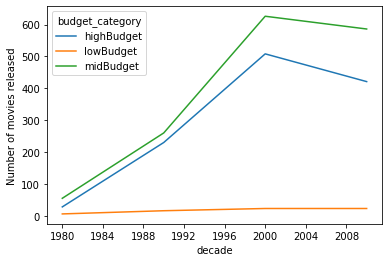

In [51]:
#Separating by decade
union_db_adjusted['decade']=union_db_adjusted['year'].dt.year//10*10

#Print Graph Number of movies released x Decade
ax=pd.crosstab(union_db_adjusted['decade'], union_db_adjusted['budget_category']).plot.line()
ax.set_ylabel('Number of movies released')
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

union_db_adjusted.set_index(union_db_adjusted['year'].dt.year, inplace=True)

Our database for low budget movies is small anda unreliable - 69 low budget movies in three decades, probably available due to its unlikely popularity. So our analysis will be restricted to high and mid budget movies.

# Final Analysis


In [52]:
##Summaring all movies information
summary_df=summarize(union_db_adjusted)

budgetCategory
highBudget    AxesSubplot(0.125,0.125;0.775x0.755)
midBudget     AxesSubplot(0.125,0.125;0.775x0.755)
Name: budget_mean, dtype: object

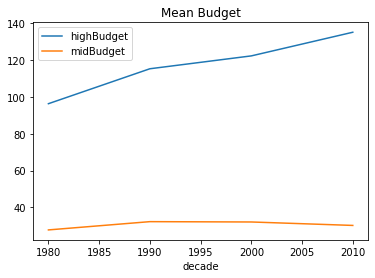

In [53]:
#Droping low budget movies
summary_df=summary_df.drop(summary_df[summary_df.budgetCategory=="lowBudget"].index)

#Printing Graph Mean Budget x Decade Graph by budget category
summary_df.set_index('decade', inplace=True)
summary_df.groupby('budgetCategory')['budget_mean'].plot(title='Mean Budget',legend=True)






budgetCategory
highBudget    AxesSubplot(0.125,0.125;0.775x0.755)
midBudget     AxesSubplot(0.125,0.125;0.775x0.755)
Name: returnRate_mean, dtype: object

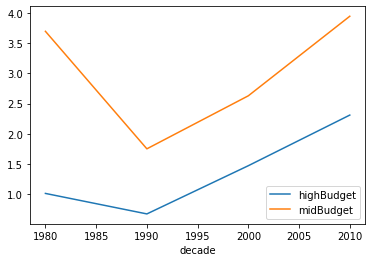

In [54]:
#Printing Mean Return Rate Graph x Decade by budget category
summary_df.groupby('budgetCategory')['returnRate_mean'].plot(legend=True)

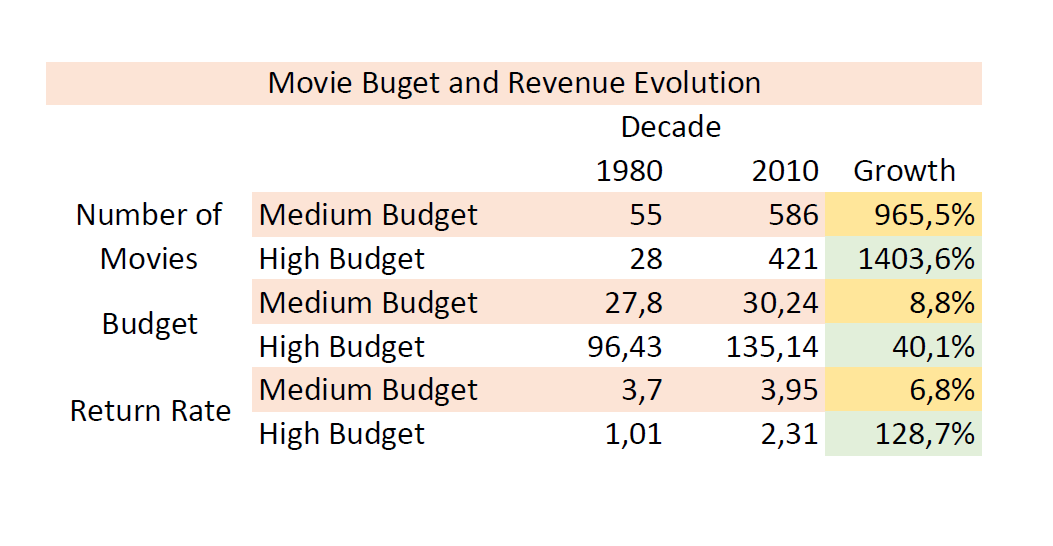

>The number of mid budget movies grew 965,5%(from 55 to 586 each decade), while the number of high budget movies grew 1403,6% (from 28 to 421)

>The mean budget for mid budget grew 8,8% and for high budget movies grew 40%

>The return rate of mid budget grew 6,8% return rate for high budget movies grew 128,7%

---
The high budget movie industry grew in every aspect, its return rate grew much more then the medium budget movie. Obviosly it is good business and studios invest heavily, both in production and marketing. But really analyze the viewers' preference, isolating the effect of big marketing campaings, we should analyze other metrics such as second week box office drop and long term viewers' scores.






# Loading and saving CSV

## Saving CSV

In [ ]:
movies_df.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/movie_revenue_TMDB.csv')
movies_df_clean.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/movie_revenue_clean.csv')
inflation.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/inflation.csv',index=False)
movies_df_prepared.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/movie_revenue_prepared.csv')
db_IMDB_TMDB_GOOGLE.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/db_IMDB_TMDB_GOOGLE.csv'
union_db.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/unionDB.csv',index=False)

## Recovering CSV

In [4]:
movies_df=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/movie_revenue_TMDB.csv')
movies_df_clean=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/movie_revenue_clean.csv')
movies_df.head()
inflation=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/inflation.csv')
movies_df_prepared=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/movie_revenue_prepared.csv')
db_IMDB_TMDB_GOOGLE=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/db_IMDB_TMDB_GOOGLE.csv')




movies_df_clean['release_date']=pd.to_datetime(movies_df_clean['release_date'])
movies_df_prepared['release_date']=pd.to_datetime(movies_df_prepared['release_date'])
inflation['Date']=pd.to_datetime(inflation['Date'])


tmdb_df=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/movie_revenue_TMDB.csv')
imdb_df=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/annual_mojo.csv')


union_db=pd.read_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/unionDB.csv', index_col=[0])



In [23]:
inflation= inflation.drop("Unnamed: 0.1",axis=1)
inflation= inflation.drop("Unnamed: 0.1.1",axis=1)
inflation= inflation.drop("Unnamed: 0.1.1.1",axis=1)
inflation= inflation.drop("Unnamed: 0.1.1.1.1",axis=1)

inflation.to_csv('/content/gdrive/MyDrive/MovieBudgetEvolution/inflation.csv',index=False)